# Forecasting with SARIMAX
This notebook walks through time series forecasting using the SARIMAX model on the AirPassengers dataset.

In [ ]:
!pip install statsmodels scikit-learn

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load dataset
from statsmodels.datasets import get_rdataset
dataset = get_rdataset('AirPassengers')
df = dataset.data
df['Month'] = pd.date_range(start='1949-01', periods=len(df), freq='M')
df.set_index('Month', inplace=True)
df.rename(columns={'value': 'Passengers'}, inplace=True)
df.head()

,time,Passengers
Month,,
1949-01-31,1949.000000,112
1949-02-28,1949.083333,118
1949-03-31,1949.166667,132
1949-04-30,1949.250000,129
1949-05-31,1949.333333,121


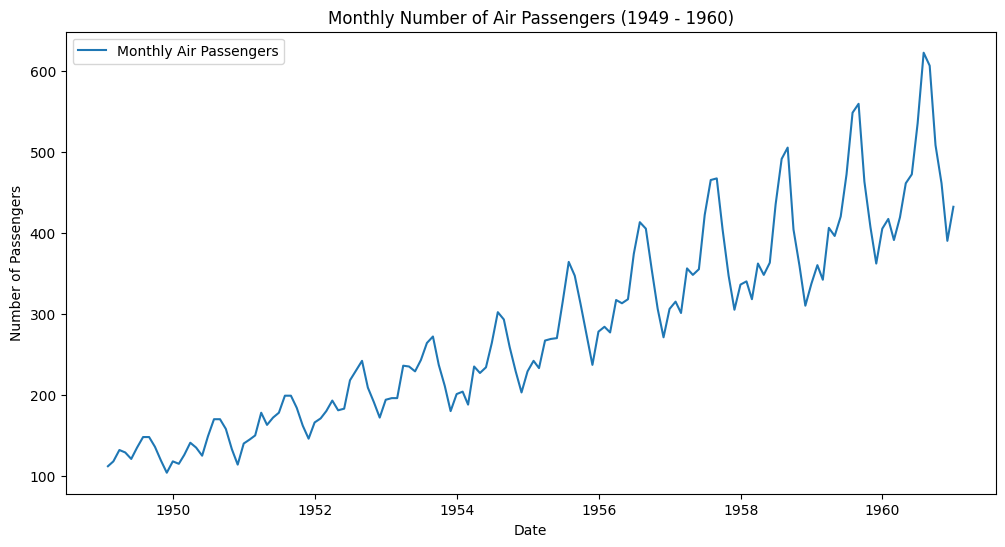

In [4]:
# Visualise the dataset
plt.figure(figsize=(12,6))
plt.plot(df['Passengers'], label='Monthly Air Passengers')
plt.title('Monthly Number of Air Passengers (1949 - 1960)')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

In [5]:
# Stationarity check
result = adfuller(df['Passengers'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: 0.8153688792060482
p-value: 0.991880243437641


In [6]:
# Differencing
df_diff = df['Passengers'].diff().dropna()
df_diff

Month
1949-02-28     6.0
1949-03-31    14.0
1949-04-30    -3.0
1949-05-31    -8.0
1949-06-30    14.0
              ... 
1960-08-31   -16.0
1960-09-30   -98.0
1960-10-31   -47.0
1960-11-30   -71.0
1960-12-31    42.0
Name: Passengers, Length: 143, dtype: float64

In [7]:
result_diff = adfuller(df_diff)
print('ADF Statistic after differencing:', result_diff[0])
print('p-value after differencing:', result_diff[1])

ADF Statistic after differencing: -2.8292668241699994
p-value after differencing: 0.0542132902838255


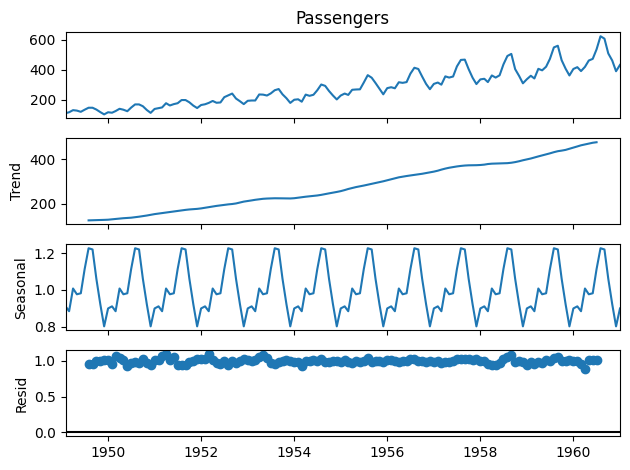

In [8]:
# Decomposition
decomposition = seasonal_decompose(df['Passengers'], model='multiplicative')
decomposition.plot()
plt.show()

In [9]:
# Train-test split
train_data = df['Passengers'][:'1959']
test_data = df['Passengers']['1960':]

In [10]:
# ARMIA model
model_arima = ARIMA(train_data,
                    order=(1, 1, 1),  # you can experiment with these
                    enforce_stationarity=False,
                    enforce_invertibility=False)
results_arima = model_arima.fit()
results_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Passengers   No. Observations:                  132
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -617.005
Date:                Thu, 05 Jun 2025   AIC                           1240.010
Time:                        16:35:05   BIC                           1248.589
Sample:                    01-31-1949   HQIC                          1243.496
                         - 12-31-1959                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5368      0.100     -5.344      0.000      -0.734      -0.340
ma.L1          0.9271      0.051     18.173      0.000       0.827       1.027
sigma2       826.9003     97.718      8.462      0.000     635.376    1018.425
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):                 2.10
Prob(Q):                              0.62   Prob(JB):                         0.35
Heteroskedasticity (H):               6.88   Skew:                            -0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

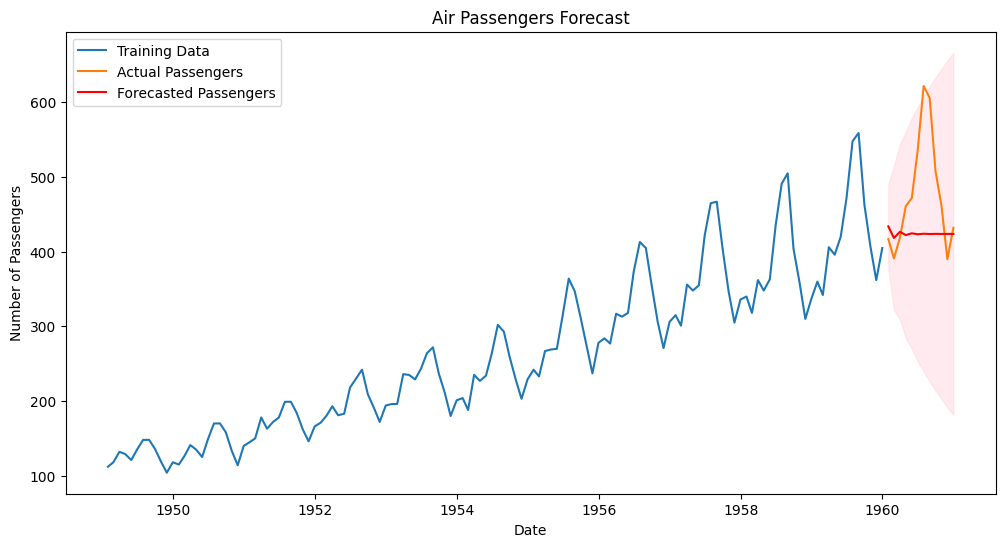

Mean Squared Error: 8281.608463842813


In [11]:
# Forecast
predictions = results_arima.get_forecast(steps=12)
pred_conf = predictions.conf_int()
plt.figure(figsize=(12,6))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Actual Passengers')
plt.plot(predictions.predicted_mean, label='Forecasted Passengers', color='red')
plt.fill_between(pred_conf.index,
                 pred_conf.iloc[:, 0],
                 pred_conf.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Air Passengers Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()
forecasted = predictions.predicted_mean
mse = mean_squared_error(test_data, forecasted)
print(f'Mean Squared Error: {mse}')

In [12]:
# SARIMAX model
model_sarimax = SARIMAX(train_data,
                        order=(1, 1, 1), # you can experiment with these
                        seasonal_order=(1, 1, 1, 12), # you can experiment with these
                        enforce_stationarity=False,
                        enforce_invertibility=False)
results_sarimax = model_sarimax.fit()
results_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         Passengers   No. Observations:                  132
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -396.681
Date:                            Thu, 05 Jun 2025   AIC                            803.363
Time:                                    16:38:16   BIC                            816.633
Sample:                                01-31-1949   HQIC                           808.740
                                     - 12-31-1959                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5400      0.338     -1.596      0.110      -1.203       0.123
ma.L1          0.3075      0.368      0.835      0.404      -0.414       1.029
ar.S.L12      -0.5925      0.204     -2.907      0.004      -0.992      -0.193
ma.S.L12       0.5235      0.291      1.801      0.072      -0.046       1.093
sigma2       108.4141     17.374      6.240      0.000      74.361     142.467
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.86
Prob(Q):                              0.93   Prob(JB):                         0.65
Heteroskedasticity (H):               1.55   Skew:                            -0.14
Prob(H) (two-sided):                  0.20   Kurtosis:                         3.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

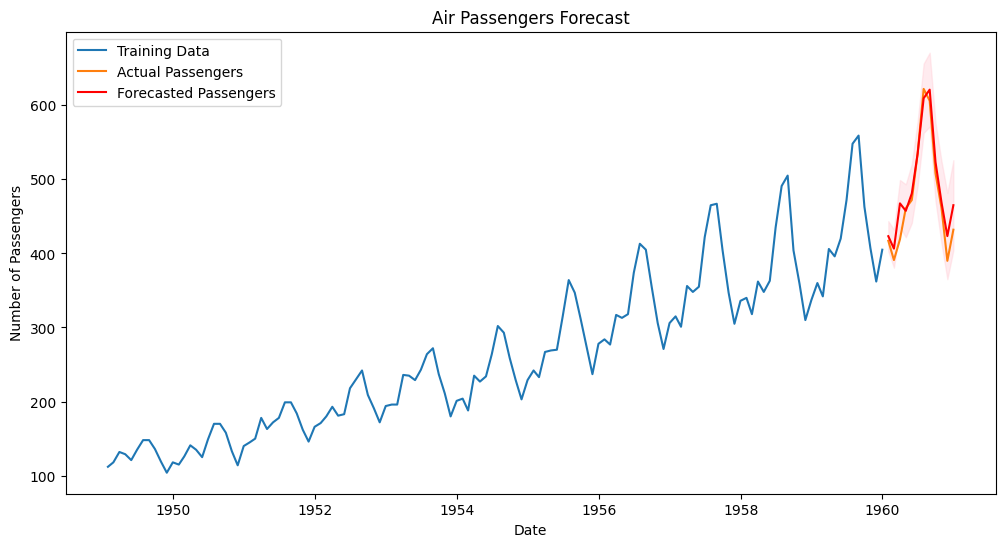

Mean Squared Error: 467.4755708445266


In [13]:
# Forecast
predictions = results_sarimax.get_forecast(steps=12)
pred_conf = predictions.conf_int()
plt.figure(figsize=(12,6))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Actual Passengers')
plt.plot(predictions.predicted_mean, label='Forecasted Passengers', color='red')
plt.fill_between(pred_conf.index,
                 pred_conf.iloc[:, 0],
                 pred_conf.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Air Passengers Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()
# Evaluation
forecasted = predictions.predicted_mean
mse = mean_squared_error(test_data, forecasted)
print(f'Mean Squared Error: {mse}')